<center><h1>Making Merger Tree from m3p output</h1></center>

In [2]:
import numpy as np
import m3p_merger
import matplotlib.pyplot as plt
import importlib
import matplotlib
importlib.reload(m3p_merger)

<module 'm3p_merger' from 'C:\\Users\\David\\Google Drive\\Axion PhD\\PeakPatch\\m3p_merger\\m3p_merger.py'>

In [3]:
Omega_m0 = 0.3
Omega_r0 = 8.486e-5
h = 0.7

G = 6.674e-11 # m^3 kg^(-1) s^(-2)
Mpc = 3.086e22 # m 
Msol = 1.988e30 # kg
Mpcpkm = (1e3/3.0869e22)
H = 100*Mpcpkm*h # /s
Omega_DM = 0.267

rho_c = 3/(8*np.pi*G)*Mpc**3/Msol*H**2 # Msol / Mpc^(-3)
rho_bg = 0.267*rho_c

z_eq = Omega_m0/Omega_r0 - 1
a_eq = 1/(1+z_eq)


In [4]:
# Peak patch data
pathPrefix = "/usr/users/ellis/PeakPatch/m3p/axOut/"

In [5]:
#ppFile = pathPrefix+"../inputs/"+"inputs.ax_manyz"
ppFile = "inputs.axbig_manyz2"
peak_list, boxsize = m3p_merger.MakePeakList(ppFile,startIndex = 0, printOutput = True)

	Loading file (100 of 100): axOut/axion_big2final_halos_99.hdf5


In [67]:
peak_list.shape

(100,)

<h2><center>Find which trees are interesting</center></h2>

In [6]:
out = m3p_merger.BuildMergerTree(peak_list, ppFile, 
                redshift_indicies='all', final_halos_indicies=np.arange(300))

for i in range(len(out)):
    if len(out[i][25]) > 2:
        print(i, end = '* ')

C:\Users\David\Google Drive\Axion PhD\PeakPatch\m3p_merger\m3p_merger.py:269: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if final_halos_indicies == 'all':


17* 45* 

<h2><center>Calculate Merger Tree</center></h2>

In [7]:
importlib.reload(m3p_merger)
#indicies = np.arange(1000)
out = m3p_merger.BuildMergerTree(peak_list, ppFile, final_halos_indicies = 17)
#np.save("./FinalGraphs/Data/MergerTreeExample.npy",out[0])

<h2><center>Plot all peaks on each other</center></h2>

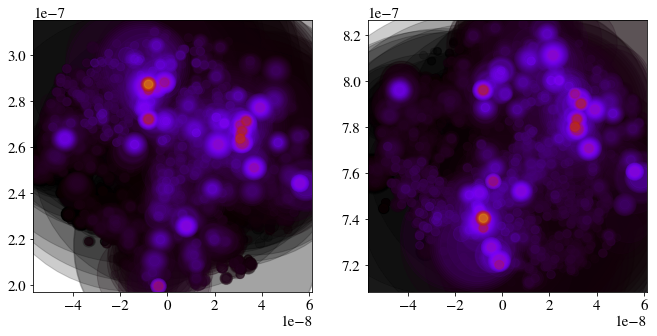

In [8]:
importlib.reload(m3p_merger)
#out = m3p_merger.BuildMergerTree(peak_list, ppFile, final_halos_indicies = 797, printOutput = True)
m3p_merger.plotMergerPatches(out[0], ppFile)

<h2><center>Plot merger tree</center></h2>

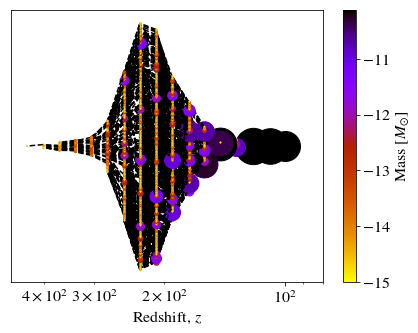

In [14]:
importlib.reload(m3p_merger)

fig = m3p_merger.plotMergerTree(out[0][::5], ppFile, startIndex=0, font_size = 16, log = True,
                          colorbar=True, colorbar_title = "Mass [$M_{\odot}$]")

<h3>Checking Linear Interpolation</h3>

(10000.0, 100.0)

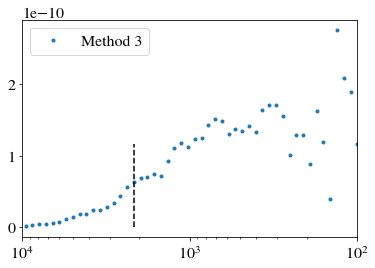

In [17]:
importlib.reload(m3p_merger)

halo_index = 45
f = 0.01

out = m3p_merger.BuildMergerTree(peak_list, ppFile, final_halos_indicies = halo_index)
#zColLin, ProgMassLin, zLin = m3p_merger.FindCollapseRedshift(out[0], f, ppFile,startIndex = 25, interp = "Linear")
zCol, ProgMass, z = m3p_merger.FindCollapseRedshift(out[0], f, ppFile,startIndex = 0, interp = "None")
plt.semilogx(z, ProgMass, '.', ms=6)
#plt.semilogx(zLin[zLin == max(zLin[ProgMassLin>=ProgMassLin[0]/2])],
#             ProgMassLin[zLin == max(zLin[ProgMassLin>=ProgMassLin[0]/2])], 'r.')

#plt.semilogx([zColLin, zColLin], [0,ProgMassLin[0]],'k-')
plt.semilogx([zCol, zCol], [0,ProgMass[0]],'k--')

plt.semilogx([2e4, 1e4], [ProgMass[0]/2,ProgMass[0]/2],'g--')
plt.legend()
plt.xlim(1e4, z[0])


#np.save("./FinalGraphs/Data/MassGrowth.npy", [z, ProgMass, zCol])

In [19]:
importlib.reload(m3p_merger)
ppFile = "inputs.axbig_manyz"

frac = 0
startIndicies = [0, 25, 50, 74]

for i, startIndex in enumerate(startIndicies):  
    z0 = np.logspace(2,6,100)[startIndex]
    
    print("-"*40)
    print("Calculating collapse redshifts\n   ppFile: {}\n   z0={:.3}\n".format(ppFile, z0))
    
    print("Building peak list...")
    peak_list, boxsize = m3p_merger.MakePeakList(ppFile, startIndex = startIndex, printOutput = True)
    print("Done.\n")

    print("Building merger trees...")
    out = m3p_merger.BuildMergerTree(peak_list, ppFile, final_halos_indicies = "all", printOutput = True)
    print("Done.\n")

    print("Calculating collapse redshifts...")
    collapse_redshifts = np.zeros(len(out))
    for i in range(len(out)):
        collapse_redshifts[i] = m3p_merger.FindCollapseRedshift(out[i], frac, ppFile, interp = "None")[0]
    print("Done.\n")

    print("Fetching final halo masses...")
    masses = np.zeros(len(out))
    for i in range(len(out)):
        masses[i] = out[i][0][0,4]
    print("Done.\n")

    print("Fetching final halo radii...")
    radii = np.zeros(len(out))
    for i in range(len(out)):
        radii[i] = out[i][0][0,3]
    print("Done.\n")

    print("Saving data...")
    np.save("ConcEvolution/axbig_manyz_CollapseRedshifts_f0_z0_{}".format(z0), collapse_redshifts)
    np.save("ConcEvolution/axbig_manyz_FinalMasses_f0_z0_{}".format(z0), masses)
    np.save("ConcEvolution/axbig_manyz_FinalRadii_f0_z0_{}".format(z0), radii)
    print("Done.\n")

----------------------------------------
Calculating collapse redshifts
   ppFile: inputs.axbig_manyz
   z0=1e+02

Building peak list...
	Loading file (100 of 100): axOut/axionfinal_halos_99.hdf5
Done.

Building merger trees...
	Final redshift index 99 out of 100
	i.e. Earlist halo at z = 1000000.0
	Halo 3110 of 3111: 99 complete of 99
Done.

Calculating collapse redshifts...
Done.

Fetching final halo masses...
Done.

Fetching final halo radii...
Done.

Saving data...
Done.

----------------------------------------
Calculating collapse redshifts
   ppFile: inputs.axbig_manyz
   z0=1.02e+03

Building peak list...
	Loading file (75 of 75): axOut/axionfinal_halos_99.hdf5
Done.

Building merger trees...
	Final redshift index 74 out of 75
	i.e. Earlist halo at z = 97700.0
	Halo 125458 of 125459: 74 complete of 74
Done.

Calculating collapse redshifts...
Done.

Fetching final halo masses...
Done.

Fetching final halo radii...
Done.

Saving data...
Done.

------------------------------------

In [99]:
np.where(zs == min(zs[zs>2507]))

(array([35], dtype=int64),)

In [97]:
zs[10]

253.53644939701115

array([array([[1.4765625e-08, 6.7204689e-07, 1.9785938e-07, 4.5879971e-09,
        3.5040550e-14]], dtype=float32),
       array([[1.8140627e-08, 6.7289068e-07, 1.9617188e-07, 4.2283728e-09,
        2.7429720e-14]], dtype=float32),
       array([[1.2234375e-08, 6.7035938e-07, 1.9617188e-07, 2.9086620e-09,
        8.9285565e-15],
       [1.8140627e-08, 6.7289068e-07, 1.9617188e-07, 4.2166244e-09,
        2.7201713e-14]], dtype=float32),
       array([[1.5609377e-08, 6.7120317e-07, 1.9954688e-07, 2.3998219e-09,
        5.0146256e-15],
       [1.2234375e-08, 6.7035938e-07, 1.9617188e-07, 2.8522431e-09,
        8.4190103e-15],
       [1.8140627e-08, 6.7289068e-07, 1.9617188e-07, 4.1396264e-09,
        2.5738602e-14]], dtype=float32),
       array([[1.4765625e-08, 6.7204689e-07, 1.9785938e-07, 4.1930899e-09,
        2.6748780e-14]], dtype=float32),
       array([[1.4765625e-08, 6.7204689e-07, 1.9785938e-07, 4.1720338e-09,
        2.6347837e-14]], dtype=float32),
       array([[1.4765625e-08

In [8]:
2/3*(1-0.6)

0.26666666666666666